# What climatic factors contribute to huge fire seasons in the western US?

The [2018 California fire season](https://en.wikipedia.org/wiki/2018_California_wildfires) was the deadliest on record. It was also the second largest in terms of area burned, surpassed only by 2020.  

This project aims to first characterize anomalies in the large-scale dynamic environment in the year leading up to the 2018 wildfire season, and then to use at a time series of burned area in California to see whether these atmospheric anomalies are typical of high fire seasons.

For the atmospheric data, I use monthly means of daily means from ERA-Interim, a global reanalysis dataset from the ECMWF that covers 1979-2018. The burned area dataset is the MBTS product, from the US Forest Service, which has been reprocessed into monthly 12km grids in an equal-area projection by Park Williams. The MBTS product is a satellite-derived record of wildfires larger than 1000 acres from 1984-2018.

In [37]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns
import rioxarray
import geopandas
from shapely.geometry import mapping
import scipy.stats as stats

%matplotlib inline

def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

def fix_coords(ds):
    ds = ds.assign_coords(X=(((ds.X + 180) % 360) - 180)).sortby(['X','Y']).rename({'X':'lon','Y':'lat'})
    return ds

period= slice('2017-12-16','2018-11-16')

In [2]:
# get gdrivefs
!pip install fsspec==0.8.4
!pip install 'git+git://github.com/tjcrone/gdrivefs.git@540a55fae06cbed4f7d9f8d540ac29fcb640c38a'
import gdrivefs

url = 'https://drive.google.com/drive/folders/1Bvu75Wk3haY6Rdz6bXB99HcHcrZlCf-2?usp=sharing'
gdfid = '1Bvu75Wk3haY6Rdz6bXB99HcHcrZlCf-2'
gdfs = gdrivefs.GoogleDriveFileSystem(root_file_id=gdfid,token='cache')

  Cloning git://github.com/tjcrone/gdrivefs.git (to revision 540a55fae06cbed4f7d9f8d540ac29fcb640c38a) to /tmp/pip-req-build-22ait39l
  Created wheel for gdrivefs: filename=gdrivefs-0+untagged.18.g540a55f-py3-none-any.whl size=7302 sha256=8e6a8849bdf53aa28e92add86ed61f9030c2db4f23ad1b5394030345b6802d5f
  Stored in directory: /home/jovyan/.cache/pip/wheels/15/4c/f1/4e7c595331abdbc521e37b85bfe0bac4d9ade7a651260cb97f
Successfully built gdrivefs


In [5]:
# open ERA-Interim pre-processed data
%%time
f = gdfs.open('ERA-I_v0.nc')

# the datavars in this dataset were individual .nc files downloaded from kage.ldeo.columbia.edu and merged
# the time, lat and lon coordinates as well as units for the fields have already been fixed/adjusted
ds = xr.open_dataset(f).drop('P').load()

CPU times: user 3.59 s, sys: 4.05 s, total: 7.64 s
Wall time: 22.4 s


Vapor pressure deficit (VPD) is a measure of dryness in the atmosphere. VPD is the difference between the actual moisture content of the air (actual vapor pressure) and the amount of moisture that the air can hold when saturated (saturation vapor pressure), and correlates well with forest fires in the western United States over past decades. Below I compute VPD using 2 meter temperature and 2 meter dew-point temperature and add it to the dataset.

In [6]:
# calculate VPD 
es0 = 6.11 #mb
c1 = 17.67 
T0 =  273.15 #K
es_a = es0*np.exp(c1*(ds.t2m - T0)/(ds.t2m - T0 + 243.5))
ea = es0*np.exp(c1*(ds.d2m - T0)/(ds.d2m - T0 + 243.5))
VPD = es_a - ea
VPD.attrs['units'] = 'mbar'

# add to dataset
ds['VPD'] = VPD
ds

<xarray.Dataset>
Dimensions:  (T: 488, lat: 181, lon: 360)
Coordinates:
  * T        (T) object 1979-01-16 00:00:00 ... 2019-08-16 00:00:00
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    tp       (T, lat, lon) float32 0.08388508 0.08388508 ... 1.033907 1.033907
    u700     (T, lat, lon) float32 1.9051075 1.8496265 ... 1.8385315 1.8385315
    v700     (T, lat, lon) float32 3.0028257 3.0359926 ... 0.183637 0.183637
    w700     (T, lat, lon) float32 -0.009189814 -0.009189814 ... 0.0006389618
    sst      (T, lat, lon) float32 nan nan nan ... 271.4601 271.4601 271.4601
    z200     (T, lat, lon) float32 11221.675 11221.675 ... 11669.765 11669.765
    d2m      (T, lat, lon) float32 246.47754 246.47754 ... 272.69806 272.69806
    t2m      (T, lat, lon) float32 249.58856 249.58856 249.58856 ... 273.3 273.3
    VPD      (T, lat, lon) float32 0.22523987 0.22523987 ... 0.26431704

# 2017-2018 seasonal anomalies 
First, we look at how the year preceding the 2018 fall fire season was different from the 1979-2019 mean climatological atmosphere. Below are the seasonal anomalies for precipitation, 2 meter temperature, and VPD, local to the western U.S., followed by the large-scale dynamic wind, SST, and 200 mb height anomalies in the tropics and mid-latitudes. For temperature and VPD, the standardized anomaly is shown, so the anomaly divided by the climatological standard deviation, in order to adjust for high spatial variation in these variables.

DJF = mean of December, January, and February monthly data, and similarly for MAM, JJA, and SON.

In [7]:
# calculate 1979-2019 seasonal and monthly climatologies
clim_m = ds.groupby('T.month').mean()
clim_s = ds.groupby('T.season').mean()

# calculate seasonal and monthly anomalies
anom_m = ds.groupby('T.month') - clim_m
anom_s = ds.groupby('T.season') - clim_s

# calculate seasonal std
std_s = ds.groupby('T.season').std()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Precipitation (regional)

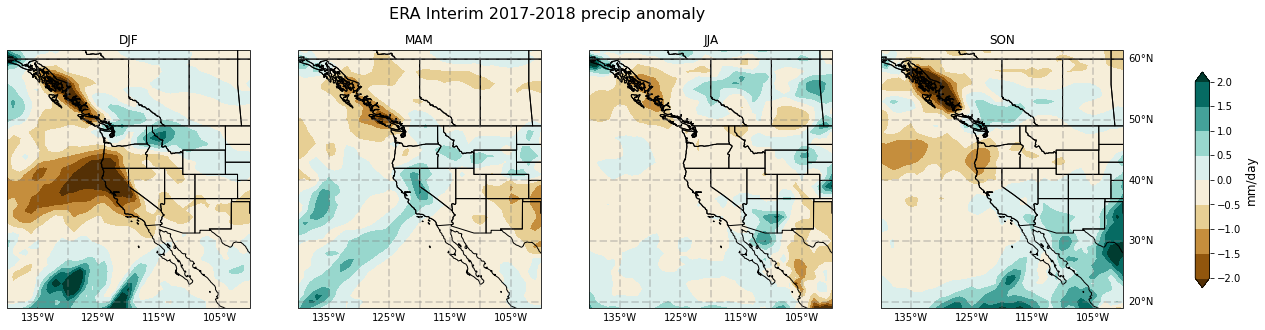

In [33]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = anom_s.tp.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2, vmax=2, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i<3:
        gl.right_labels=False
    gl.top_labels = False
    gl.left_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('ERA Interim 2017-2018 precip anomaly',fontsize=16);


Most notable in precipitation is the huge dry anomaly concentrated in Northern California in the 2017-2018 winter, and a less strong dry anomaly in the fall around the Oregon coast. 

## 2 meter temperature and VPD (regional)

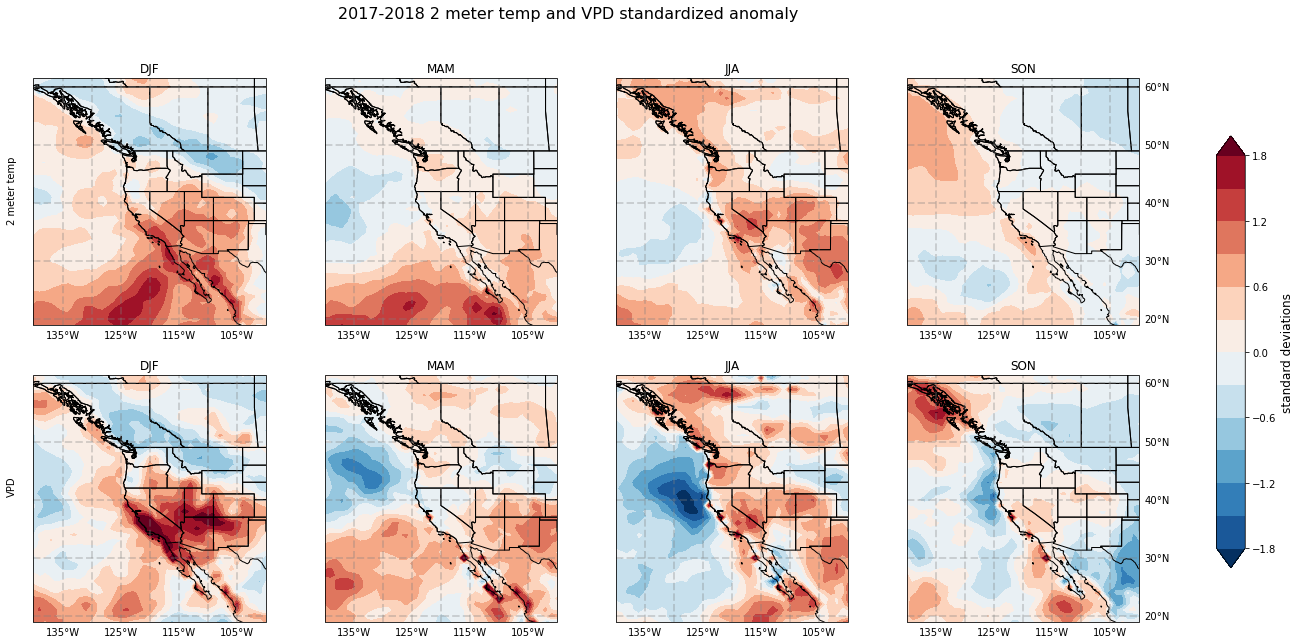

In [34]:
fig, ax = plt.subplots(2,4,figsize=(20,10))

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,4,i+1,projection=ccrs.PlateCarree())
    if i<4:
        im = (anom_s.t2m.sel(T=period).groupby('season').mean() / std_s.t2m).sel(season=seasons[i]).plot.contourf(
            ax=ax, vmin=-1.8, vmax=1.8,levels=13, cmap='RdBu_r',add_colorbar=False)
    else:
        im = (anom_s.VPD.sel(T=period).groupby('season').mean() / std_s.VPD).sel(season=seasons[i-4]).plot.contourf(
            ax=ax, vmin=-1.8, vmax=1.8,levels=13, cmap='RdBu_r',add_colorbar=False)    
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i==3 or i==7:
        gl.right_labels=True
    else:
        gl.right_labels=False
    gl.top_labels = False
    gl.left_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i-4])
    ax.set_ylabel('test')
    if i==0:
        ax.text(-0.07, 0.55, '2 meter temp', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
    if i==4:
        ax.text(-0.07, 0.55, 'VPD', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('2017-2018 2 meter temp and VPD standardized anomaly',fontsize=16);

Southern California and Baja California have an exceptionally hot and dry atmosphere in the preceding winter.

## 700mb winds and vertical velocity (global)

Text(0.5, 0.94, '2017-2018 700mb wind anomalies')

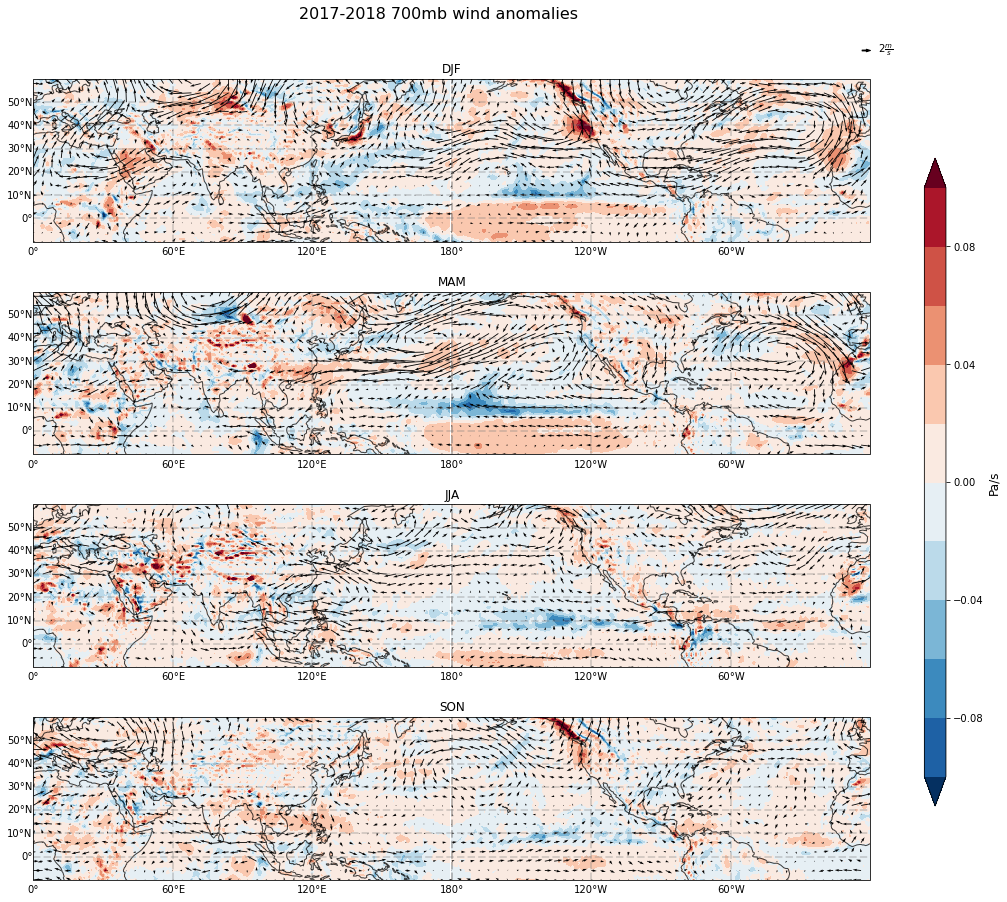

In [36]:
fig, ax = plt.subplots(4,1,figsize=(15,15))
extent = [0, 359, -10, 60]
u_plt = (anom_s.u700.sel(T=period).groupby('T.season').mean())
v_plt = (anom_s.v700.sel(T=period).groupby('T.season').mean())
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = anom_s.w700.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-0.1, vmax = .1, levels=11, cmap='RdBu_r',add_colorbar=False, transform=ccrs.PlateCarree())
    qv = ax.quiver( x[::4], y[::4], u_plt.sel(season=seasons[i]).values[::4,::4], v_plt.sel(season=seasons[i]).values[::4,::4],width=1e-3, scale = 200, color='k',
                  transform=ccrs.PlateCarree())
    ax.coastlines(alpha=0.75)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.9, 0.9 , 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='k',linewidth=1)

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='Pa/s',size=12)
plt.suptitle('2017-2018 700mb wind anomalies',fontsize=16, y=0.94)

There is a large high pressure system offshore of western North America in DJF, as well as subsidence on the eastern flank of this high pressure system. These wind anomalies combine to bring dry, high air from the north to the western U.S. This anomaly reverses in the spring.

There is also a La Nina wind anomaly in the tropical Pacific. 

## 200mb height & SST (global)

Text(0.5, 0.98, '2017-2018 SST anomaly')

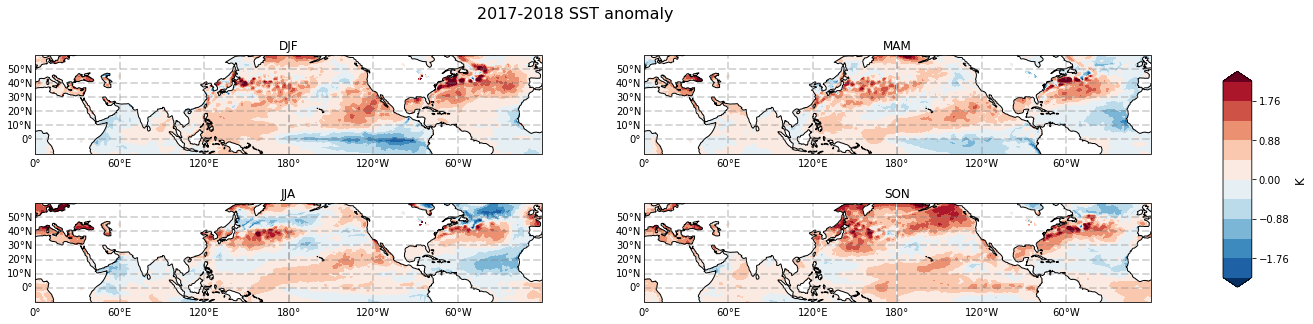

In [21]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = anom_s.sst.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2.2, vmax=2.2,levels=11, cmap='RdBu_r',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='K',size=12)
plt.suptitle('2017-2018 SST anomaly',fontsize=16);

Text(0.5, 0.98, '2017-2018 200 mbar height anomaly')

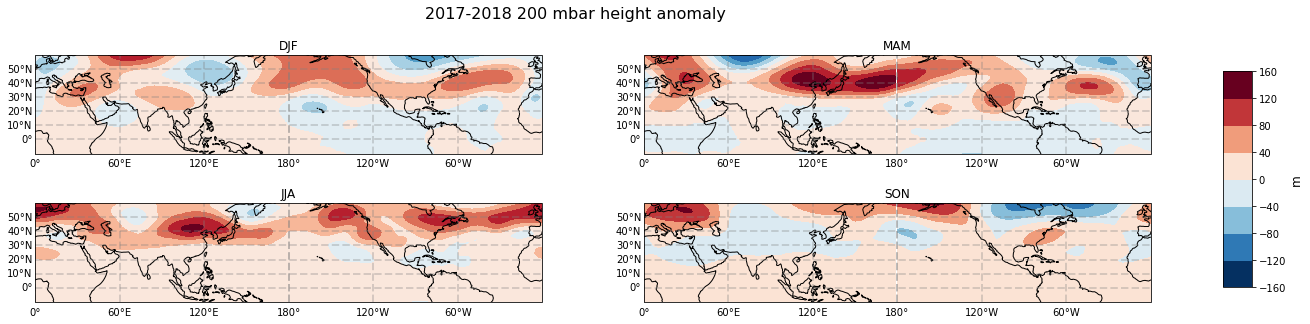

In [19]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = anom_s.z200.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, levels=11, cmap='RdBu_r',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m',size=12)
plt.suptitle('2017-2018 200 mbar height anomaly',fontsize=16)

SST anomalies show that DJF was a La Nina winter that weakens in the spring and is gone by the summer. The 200 mbar height anomaly is an ENSO teleconnection and a robust descriptor of atmospheric circulation anomalies. 

# California burned area
Next, we use a timeseries of burned area in California from 1984-2018 to see whether the DJF 200 mbar height anomaly above correlates with high fire seasons. 

In [8]:
# burn area
burn = xr.open_dataset('burnarea_mtbs_only.nc',decode_times=False)
burn = xr.decode_cf(burn, decode_times = True)
burn = burn.sel(time = slice('1984-01-15','2018-12-15'))

# set up burn with rioxarray 
burn.rio.set_spatial_dims(x_dim="X", y_dim="Y", inplace=True)
burn.rio.write_crs("epsg:5070", inplace=True)

# read california shape file
cali = geopandas.read_file('./cali/CA_State_TIGER2016.shp')

# mask burn with california shapefile
burn_cali = burn.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
burn_cali = burn_cali.sum(['X','Y'])

In [9]:
df = burn_cali.drop('spatial_ref').to_dataframe()
burn_cali_m = burn_cali.groupby('time.month')
df['month'] = df.index.month

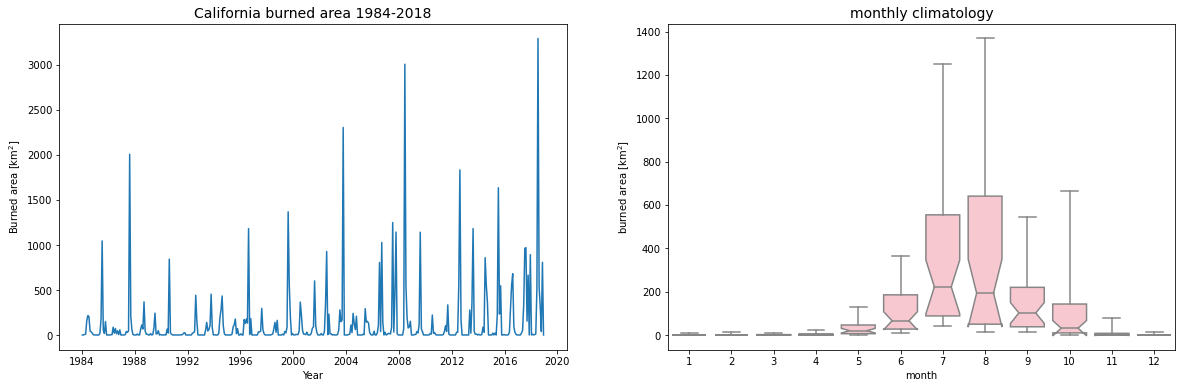

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(burn_cali.time,burn_cali.burnarea)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Burned area [km$^2$]')
ax[0].set_title('California burned area 1984-2018',fontsize=14);


sns.boxplot(data = df, x='month', y='burnarea',color='pink', showfliers=False, notch=True, whis=(5.,95.),ax=ax[1])
ax[1].set_title('monthly climatology',fontsize=14)
ax[1].set_ylabel('burned area [km$^2$]');

The whiskers in the box plot extend to the 5th and 95th percentiles of each month.

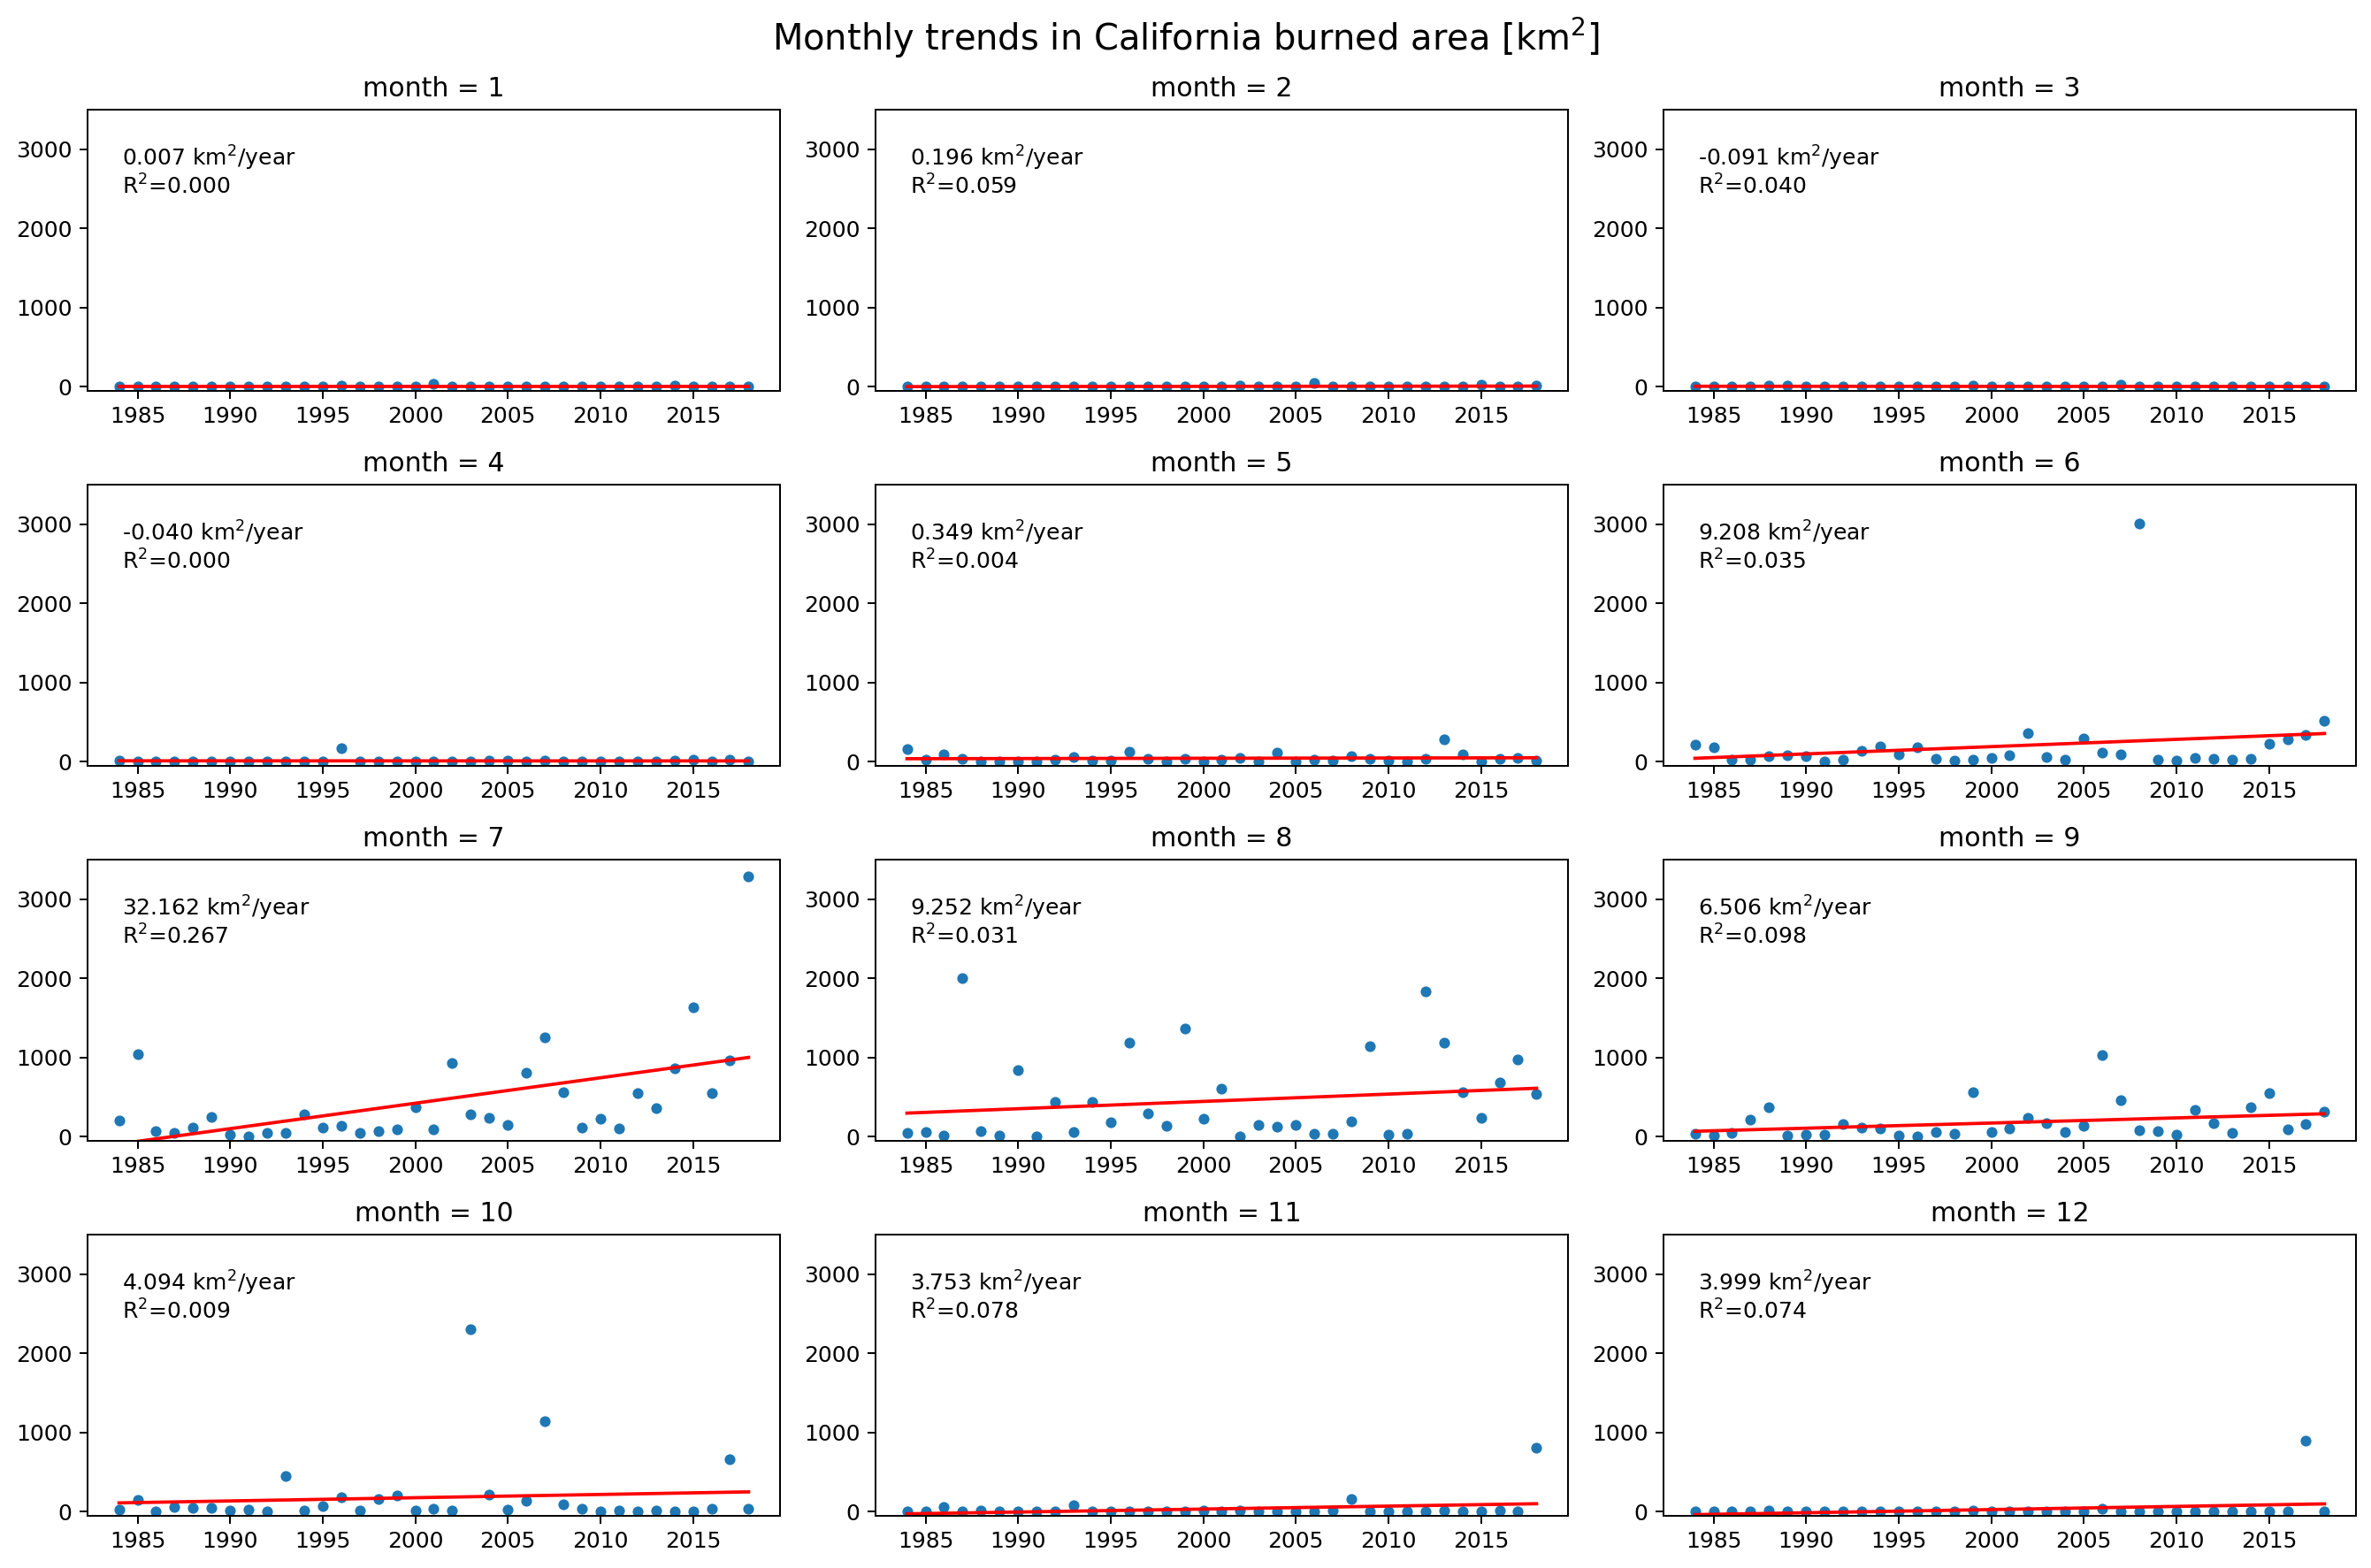

In [11]:
fig, ax = plt.subplots(4,3,figsize=(15,10),dpi=180,sharex=True)
idxs = burn_cali_m.groups

for i, ax in enumerate(ax.flatten()):
    month_idxs = idxs[1+i]
    ds=burn_cali.isel(time=month_idxs).groupby('time.year').mean()
    slope = ds.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
    intercept = ds.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
    fit = [slope * i + intercept for i in ds.year]
    resid = ds.polyfit('year',1,full=True).burnarea_polyfit_residuals
    r2 = 1 - (resid / (ds.year.size * ds.burnarea.var('year')))
    ax = plt.subplot(4,3,i+1)
    ax.text(0.05, 0.8,s=f'%.3f km$^2$/year'%slope.item(),transform=ax.transAxes)
    ax.text(0.05, 0.7,s=f'R$^2$=%.3f'%r2.item(),transform=ax.transAxes)
    ax.plot(ds.year,fit,c='r')
    ax.scatter(ds.year, ds.burnarea,s=15)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-50,3500])
    ax.set_title(f'month = {i+1}')
    ax.plot

plt.suptitle('Monthly trends in California burned area [km$^2$]', fontsize=16)
plt.tight_layout()

With this trend information, we choose July as the month to correlate with the preceding DJF 200 mbar height anomaly each year. First, we detrend the July burned area timeseries to avoid correlating with the trend.

In [13]:
ds_m7=burn_cali.isel(time=idxs[7]).groupby('time.year').mean()
slope = ds_m7.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
intercept = ds_m7.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
fit = [slope * i + intercept for i in ds.year]
ds_m7_detrend = ds_m7 - fit

In [15]:
def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return xr.DataArray(slope)

def rval(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return xr.DataArray(r_value)

In [20]:
season_idxs = anom_m.sel(T=slice('1983-12-15','2018-11-16')).groupby('T.season').groups
z200_fit = anom_m.z200.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['DJF']).resample({'T':'AS-DEC'}).mean().groupby('T.year').mean()
z200_fit = z200_fit.assign_coords(year = z200_fit.year + 1).sel(year=slice(1984,2018))
z200_burn_fit = xr.merge([z200_fit,ds_m7_detrend])
slopes = xr.apply_ufunc(linear_trend,
                        z200_burn_fit.burnarea, z200_burn_fit.z200,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval,
                        z200_burn_fit.burnarea, z200_burn_fit.z200,
                        vectorize=True,
                        input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

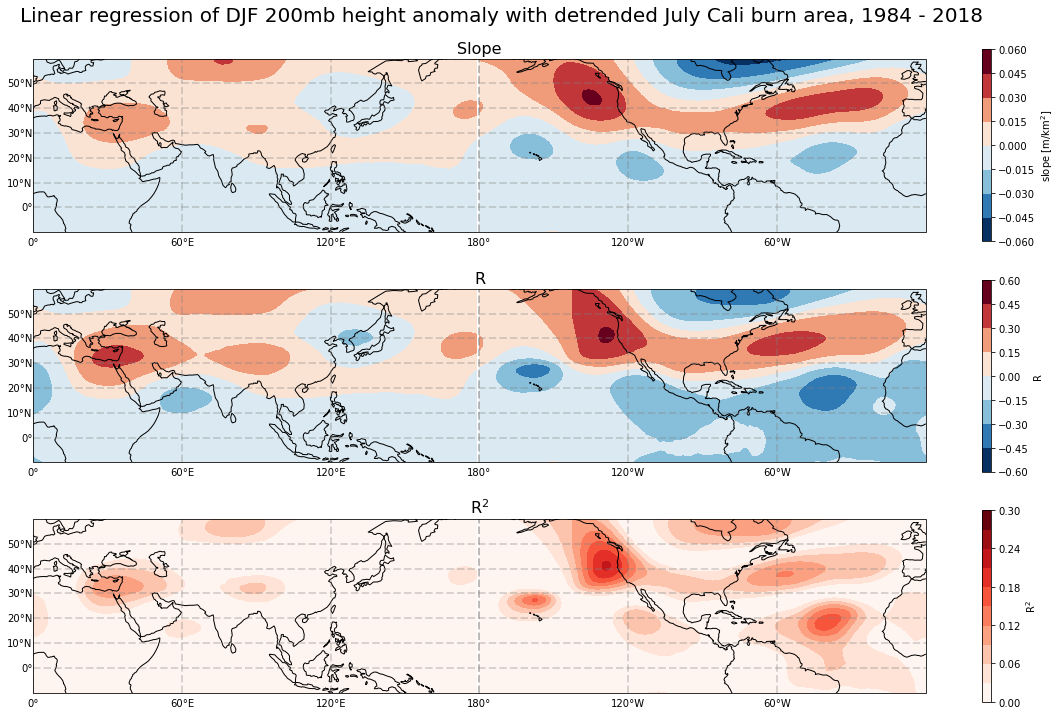

In [31]:
plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=9, cmap='RdBu_r',vmax=0.06,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [m/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',vmax = 0.3,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z200,dim='year').plot.contourf(ax=ax2, levels=9, cmap='RdBu_r',vmax=0.6,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of DJF 200mb height anomaly with detrended July Cali burn area, 1984 - 2018',fontsize=20,x=0.45,y=.93);

The correlation looks remarkably similar to the 2017-2018 DJF 200 mbar anomaly, indicating that the circulation anomalies we saw in the winter before the 2018 fire season could certainly be typical for high fire summers/fall in California.